## Quick look picture

In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

PIL mode: RGB
PIL mode: L


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/1248388930.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


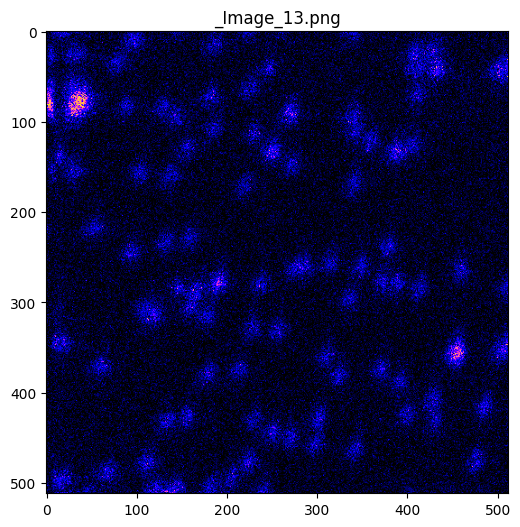

In [21]:
# open PNG image plot with matplotlib
fileDir = './4_data/trainning/200nm/'
fileName = '_Image_13.png'



img = Image.open(fileDir + fileName)
print("PIL mode:", img.mode) # mode 屬性會告訴你色彩模式

img = img.convert('L')  # convert to grayscale
print("PIL mode:", img.mode)
img_array = np.array(img)
fig1, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img_array, cmap='gnuplot2')
ax.set_title(fileName)
fig1.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/3907055257.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


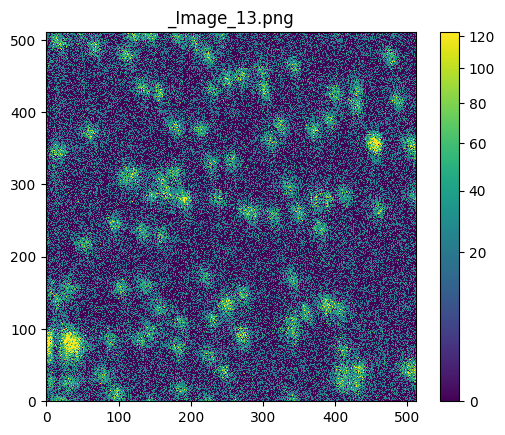

In [22]:
from vidualize import plot_picture

fig, ax = plot_picture(img_array, percent= 99.5)
ax.set_title(fileName)
fig.show()

## Background extract

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/1419233777.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


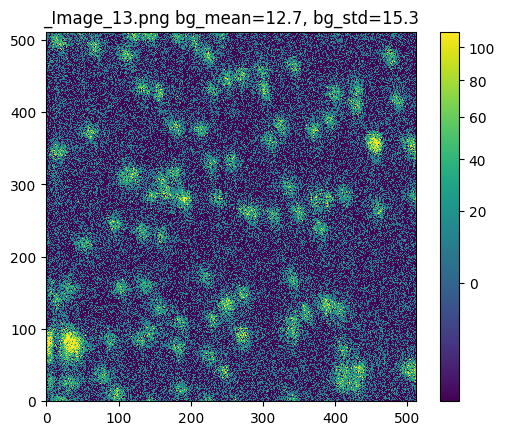

In [23]:
# viw the region that > bg_mean + kappa*std -> source
# let it be a great value to see it
from kapasigmaClip import kappaSigmaClipping

mask, bg_mean, bg_std = kappaSigmaClipping(3, 20, img_array)
image_clean_bg = img_array - bg_mean # remove background mean
fig, ax = plot_picture(image_clean_bg, percent= 99.5)
ax.set_title(fileName + f' bg_mean={bg_mean:.1f}, bg_std={bg_std:.1f}')
fig.show()


## Find source

In [24]:
from findSource import find_source, plot_source

sources = find_source(image_clean_bg, sigma=7.0, fwhm=15.0, threshold_times=3)
print(f"Found {len(sources)} sources")

Found 39 sources


## Plot source hold radius

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/2723434240.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


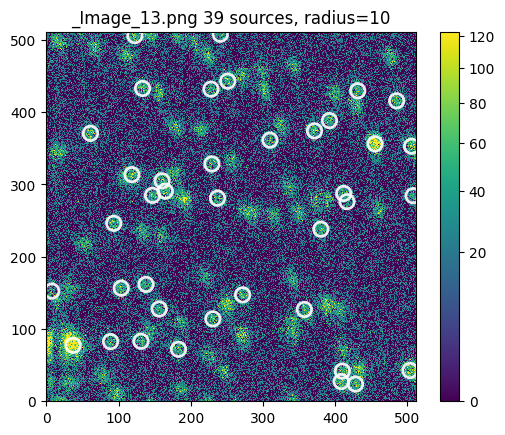

In [25]:
radius = 10
fig, ax = plot_source(img_array, sources, radius=radius, percent=99.5)
ax.set_title(f'{fileName} {len(sources)} sources, radius={radius}') 
fig.show()

## FWHM 2D fitting
Use a fix size square area (ex: 12 * 12 pixels) to fit 2D gaussian, 
the sixe of square nedd to guess based on image.

astropy.modeling models Gaussian2D
since we don't know fwhm, the fitting iteration is high, in this case = 10000

In [26]:
from fwhm2d import FWHM2d


fwhm_x_list, fwhm_y_list, mask = FWHM2d(sources, img_array, sub_size_half=12)
sources['x_fwhm'] = fwhm_x_list
sources['y_fwhm'] = fwhm_y_list
sources = sources[mask]  # only keep the sources with valid FWHM


dict_keys(['nfev', 'fvec', 'fjac', 'ipvt', 'qtf', 'message', 'ierr', 'param_jac', 'param_cov', 'njev', 'cov_x'])
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
1


Text(0.5, 1.0, '_Image_13.png with FWHM elipse')

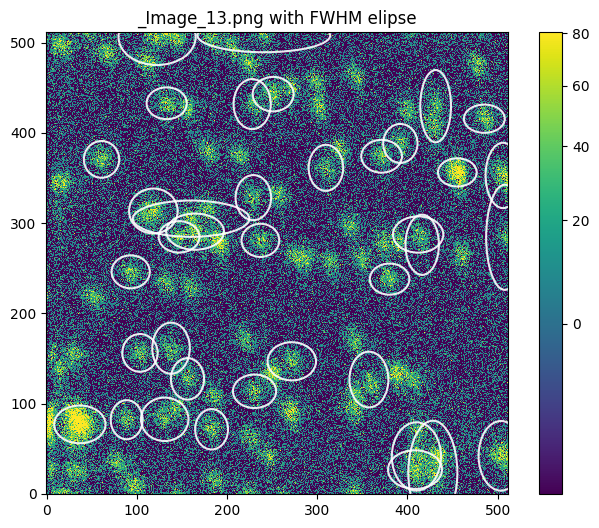

In [27]:
from fwhm2d import plot_source_fwhm_ellips

fig, ax = plot_source_fwhm_ellips(image_clean_bg, sources, figsize=(8, 6))
ax.set_title(f'{fileName} with FWHM elipse')

## Clean source with strange FWHM

### Plot FWHM distribution

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/675293388.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


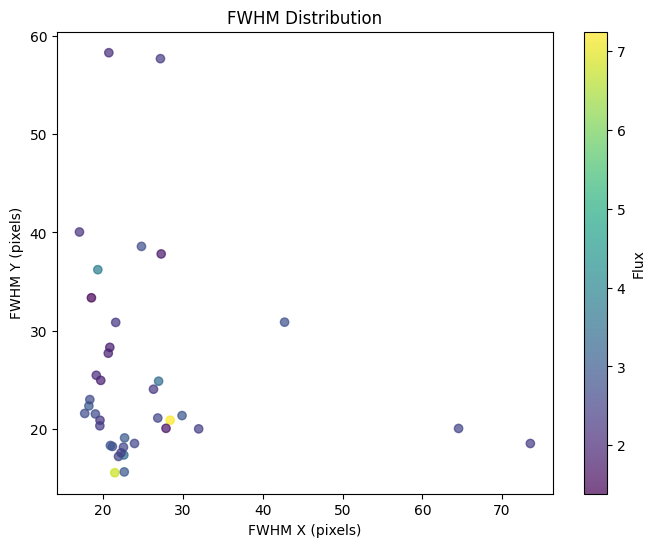

In [28]:
# plot the distribution of fwhm x y size dot plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['x_fwhm'], sources['y_fwhm'], c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (pixels)')
ax.set_ylabel('FWHM Y (pixels)')
ax.set_title('FWHM Distribution')
fig.show()

### delete FWHM > threshhold sources

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/2738919804.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


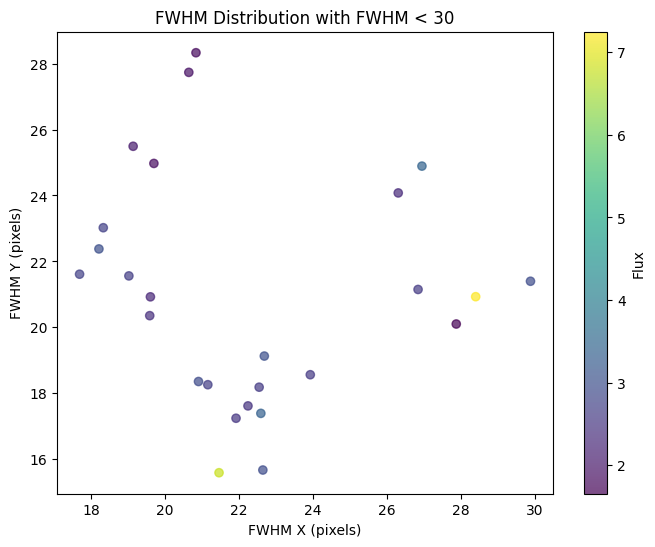

In [29]:
threshhold = 30
mask = (sources['x_fwhm'] < threshhold) & (sources['y_fwhm'] < threshhold)
sources = sources[mask]

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(sources['x_fwhm'], sources['y_fwhm'], c=sources['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (pixels)')
ax.set_ylabel('FWHM Y (pixels)')
ax.set_title(f'FWHM Distribution with FWHM < {threshhold}')
fig.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/3798657236.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


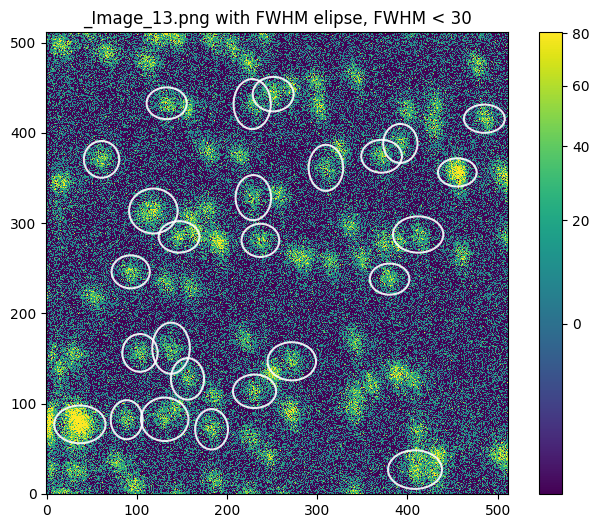

In [30]:
fig, ax = plot_source_fwhm_ellips(image_clean_bg, sources, figsize=(8, 6))
# diameter = 2 * fwhm => source. size
ax.set_title(f'{fileName} with FWHM elipse, FWHM < {threshhold}')
fig.show()

## FWHMx 1D fitting
Use FWHM 2D fitting result as initioal fitting parm fit again
not sure is this is necessary, but for plot 1D fitting convenience, just fit again...

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/1435927288.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


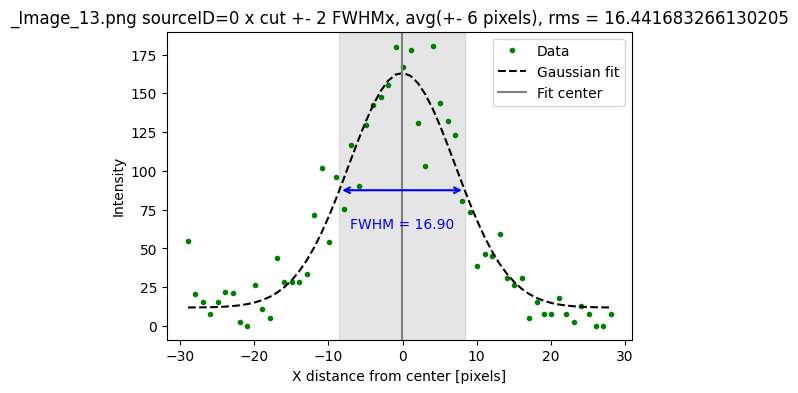

In [31]:
from fwhm1d import plot_xy_cut_gaussian
from fwhm1d import fit_gaussian_xy
avg_pixel_num = 6
sourceID = 2
axis = 'x'
parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = axis, sourceID=sourceID, avg_pixel_num=avg_pixel_num)
fig, ax = plot_xy_cut_gaussian(sources, sourceID=0, parm=parm, x_rel=main_rel_range, intensity_profile=intensity_profile, x0=x0, axis='y')
ax.set_title(f'{fileName} sourceID=0 {axis} cut +- 2 FWHMx, avg(+- {avg_pixel_num} pixels), rms = {rms}')
fig.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/4030849091.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


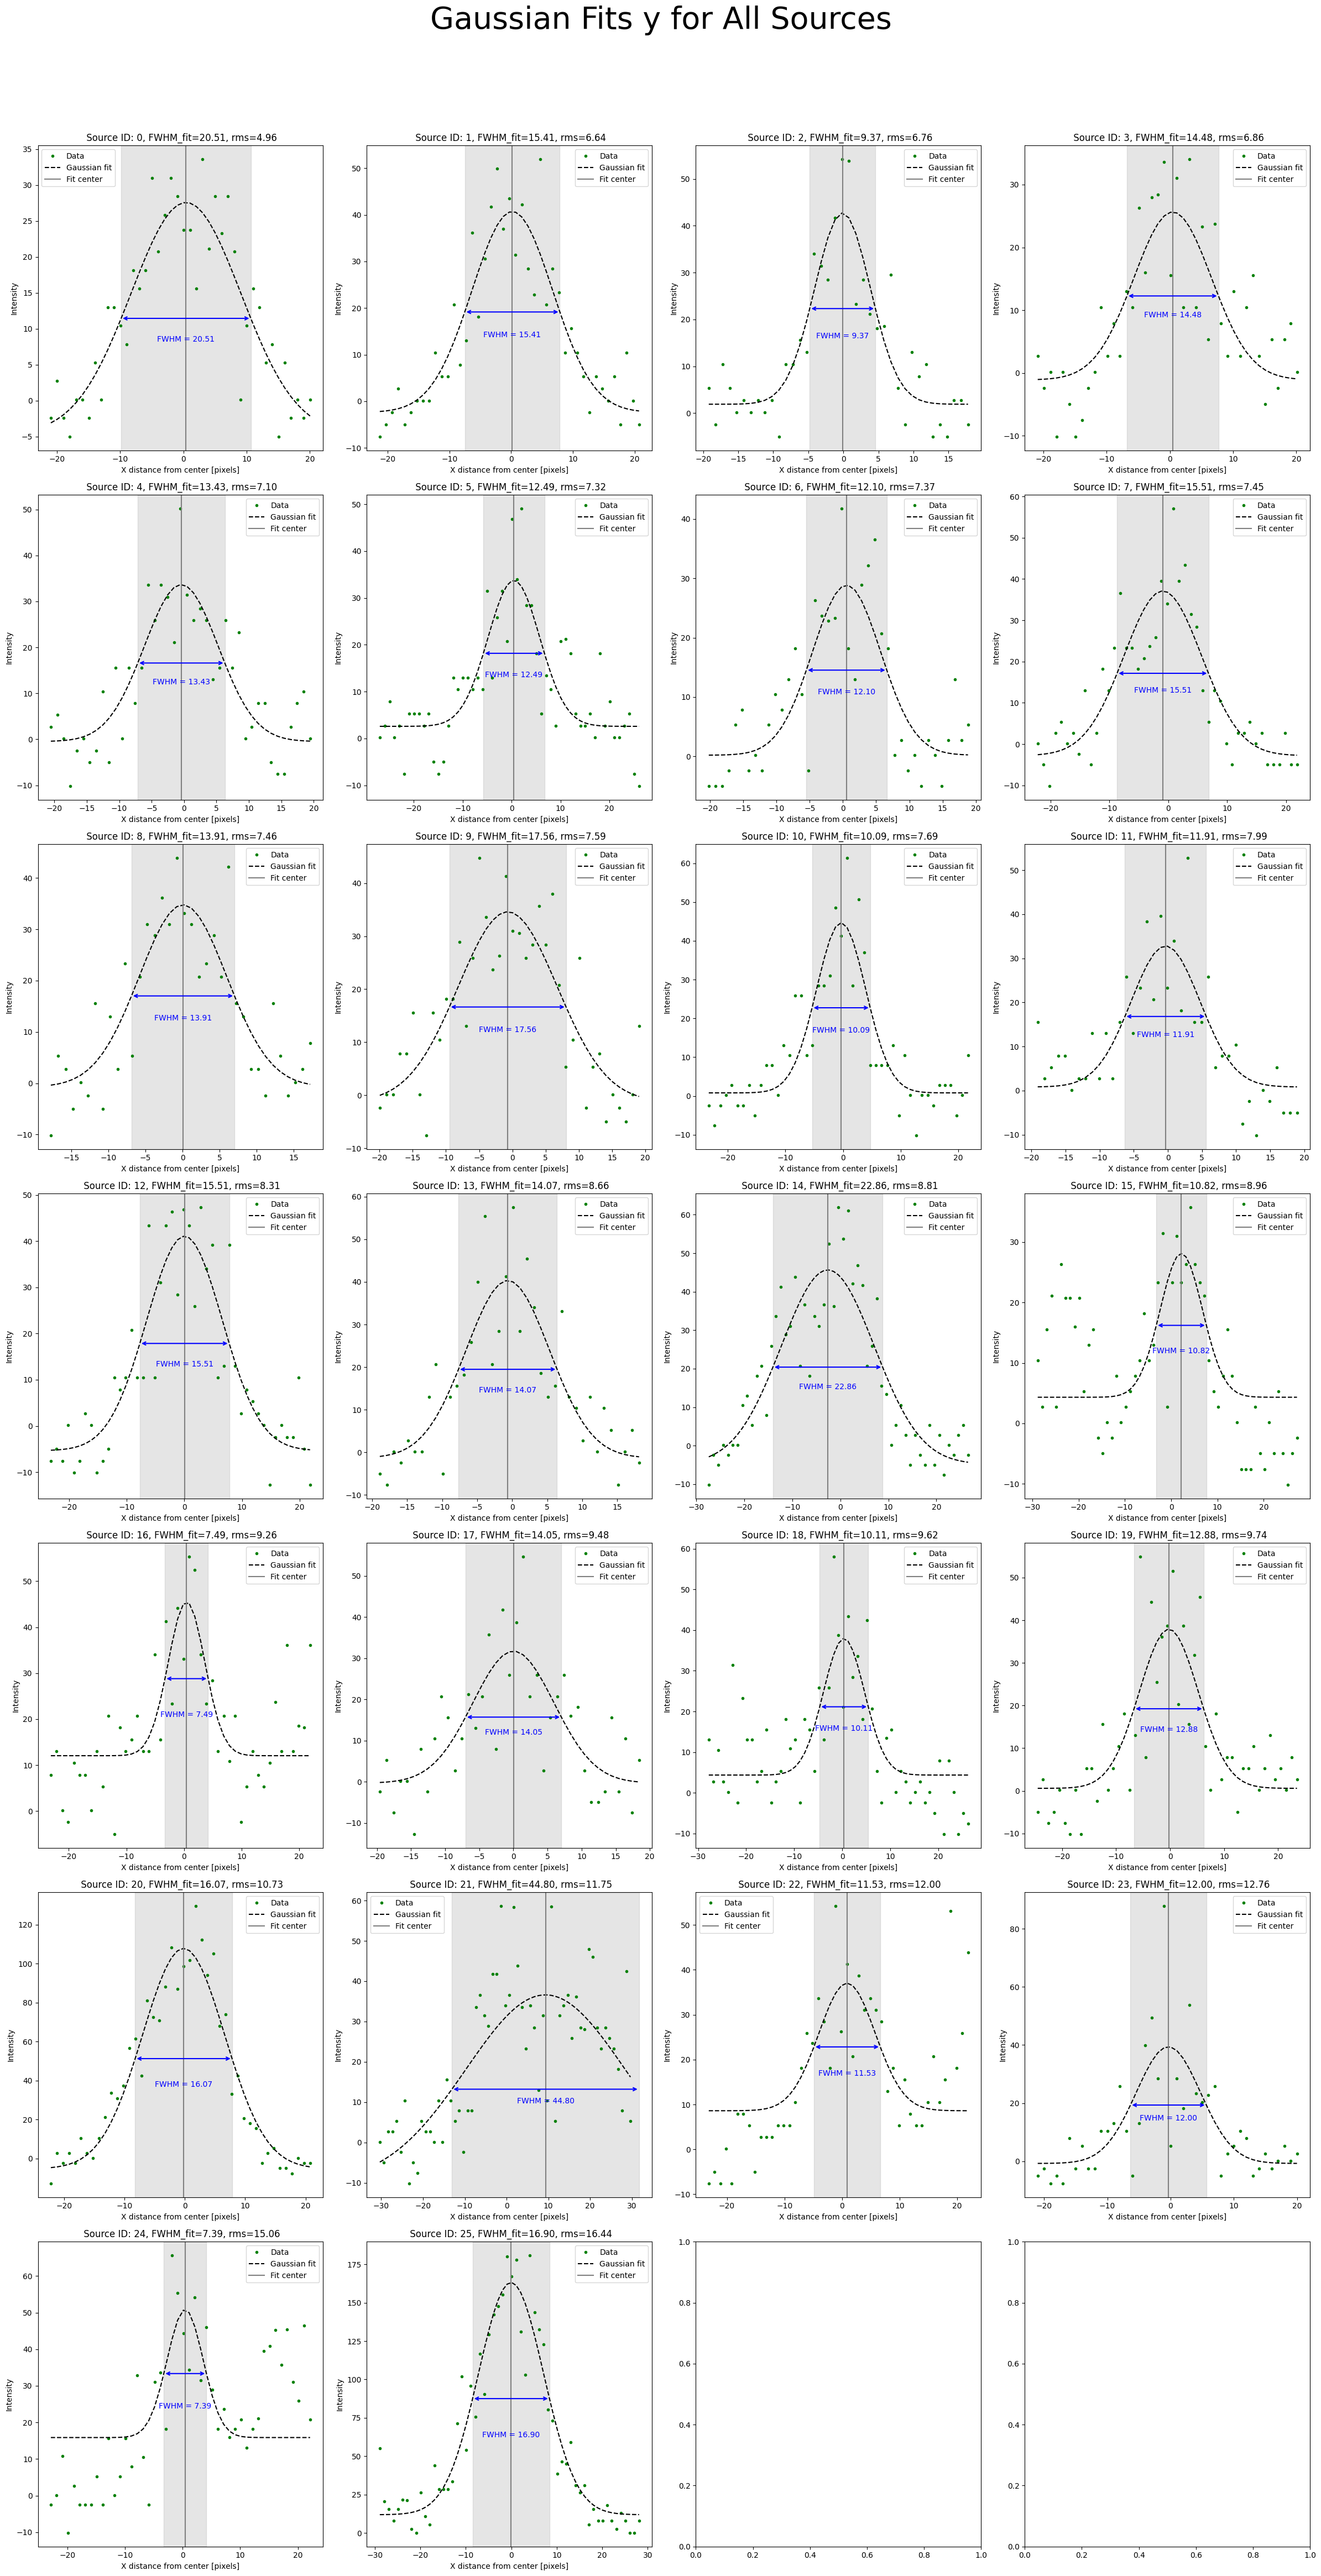

In [36]:
# for each source, plot the x cut gaussian fit and create subplots
num_sources = len(sources)
axis = 'y'
num_cols = 4
num_rows = (num_sources + num_cols - 1) // num_cols  #
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*7))
axes = axes.flatten()  # 將 2D 陣列展平為
rms_x_list = []

for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = 'x', sourceID=i, avg_pixel_num=avg_pixel_num)
    rms_x_list.append(rms)


sources['rms_fit_x'] = rms_x_list

# sort sources by rms
sources.sort('rms')
for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = 'x', sourceID=i, avg_pixel_num=avg_pixel_num)    
    fig, ax = plot_xy_cut_gaussian(sources, sourceID=0, parm=parm, x_rel=main_rel_range, intensity_profile=intensity_profile, x0=x0, axis='x', ax=axes[i])
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")

fig.suptitle(f'Gaussian Fits {axis} for All Sources', fontsize=40)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()  

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/313886698.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


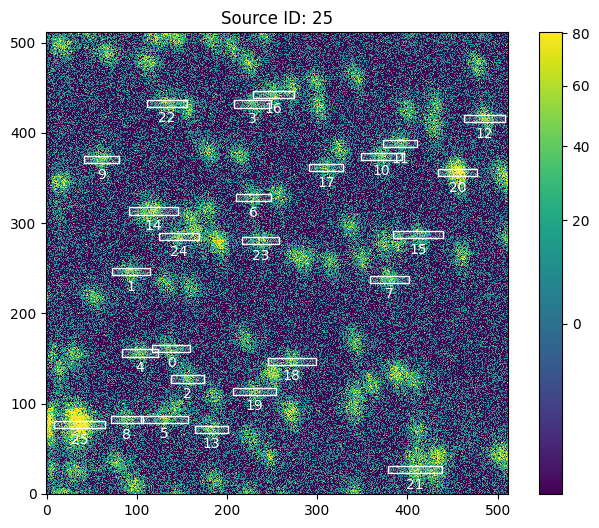

In [33]:
import matplotlib.patches as patches

source_id = 1
fig, ax = plot_picture(image_clean_bg, percent=98.5, figsize=(8, 6))

for i in range(len(sources)):
    source_id = i
    x0, y0, x_half_range, y_half_range = sources[source_id]['xcentroid'], sources[source_id]['ycentroid'], sources[source_id]['x_fwhm'], avg_pixel_num//2+1
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    ax.add_patch(rect)
    ax.set_title('Source ID: {}'.format(source_id))
    fig1.show()

## FWHMy 1D fitting

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/3784661397.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


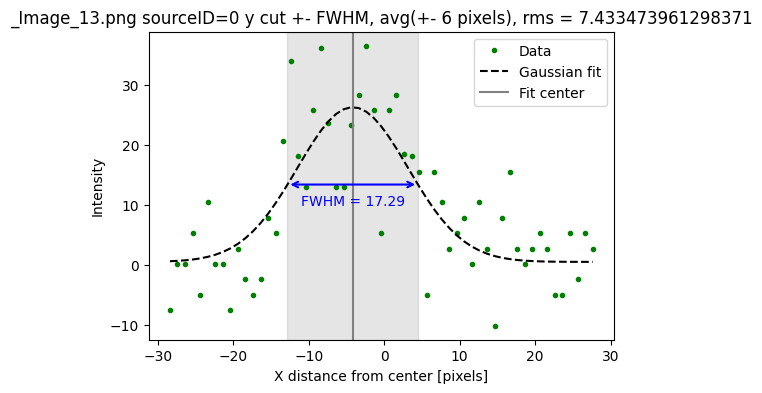

In [34]:
from fwhm1d import plot_xy_cut_gaussian
from fwhm1d import fit_gaussian_xy
avg_pixel_num = 6
sourceID = 0
axis = 'y'
parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = axis, sourceID=sourceID, avg_pixel_num=avg_pixel_num)
fig, ax = plot_xy_cut_gaussian(sources, sourceID=sourceID, parm=parm, x_rel=main_rel_range, intensity_profile=intensity_profile, x0=x0, axis='y')
ax.set_title(f'{fileName} sourceID={sourceID} {axis} cut +- FWHM, avg(+- {avg_pixel_num} pixels), rms = {rms}')
fig.show()

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/2781054582.py:27: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_21369/2781054582.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


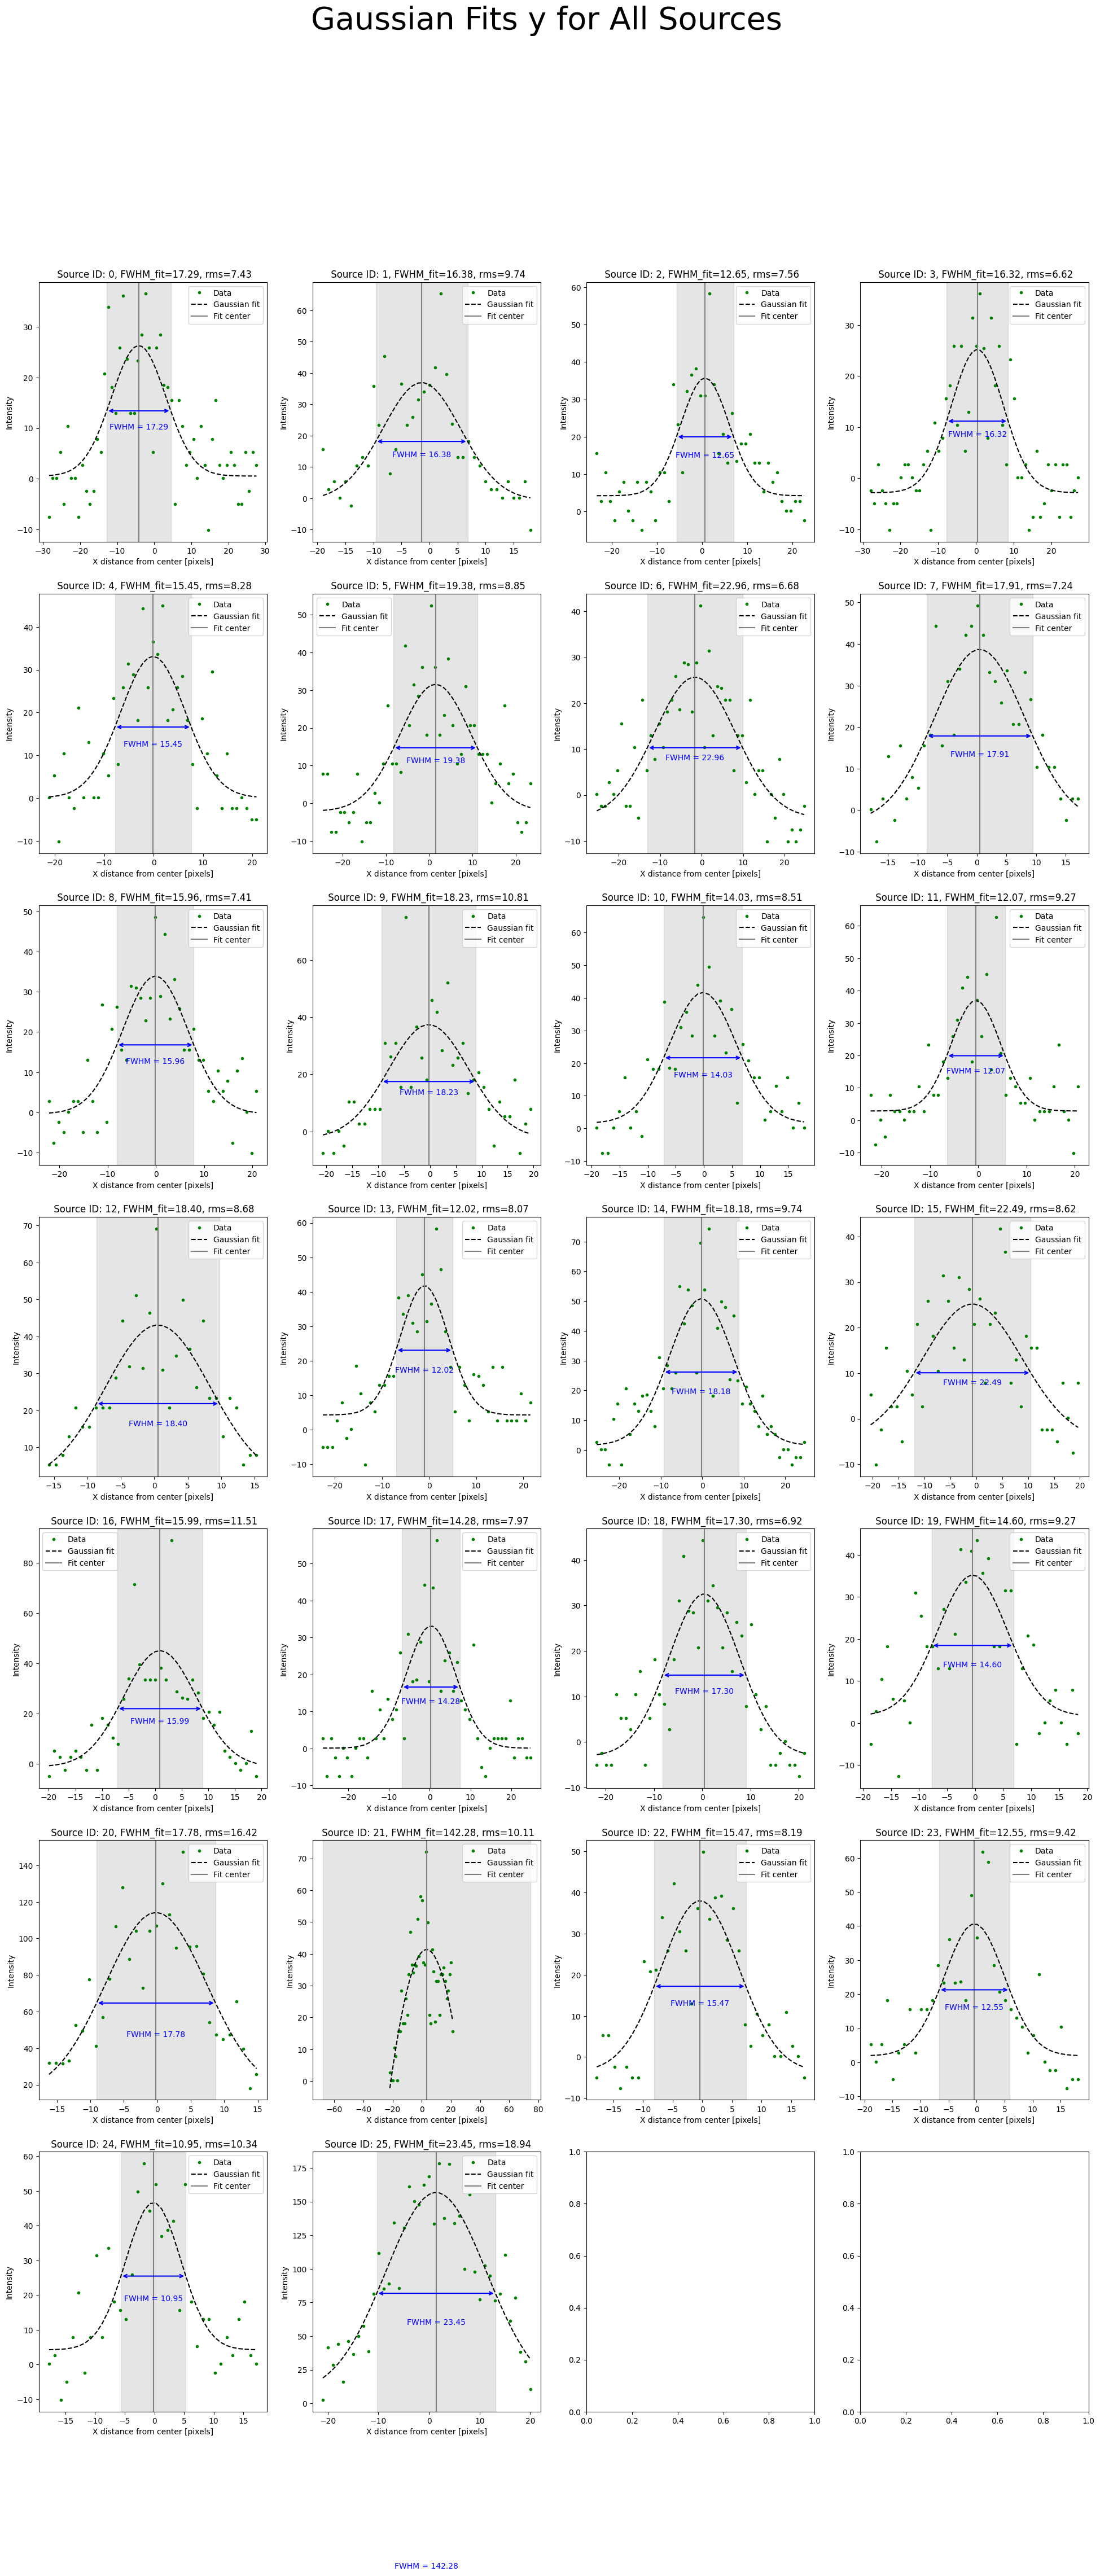

In [37]:
# for each source, plot the x cut gaussian fit and create subplots
num_sources = len(sources)
axis = 'y'
num_cols = 4
num_rows = (num_sources + num_cols - 1) // num_cols  #
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*7))
axes = axes.flatten()  # 將 2D 陣列展平為
rms_y_list = []

for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = axis, sourceID=i, avg_pixel_num=avg_pixel_num)
    rms_y_list.append(rms)


sources['rms_fit_y'] = rms_y_list

# sort sources by rms
sources.sort('rms')
for i in range(num_sources):
    parm, main_rel_range, intensity_profile, x0, y_half_range, rms = fit_gaussian_xy(image_clean_bg, sources, axis = axis, sourceID=i, avg_pixel_num=avg_pixel_num)    
    fig, ax = plot_xy_cut_gaussian(sources, sourceID=0, parm=parm, x_rel=main_rel_range, intensity_profile=intensity_profile, x0=x0, axis=axis, ax=axes[i])
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    ax.set_title(f" Source ID: {i}, FWHM_fit={fwhm_fit:.2f}, rms={rms:.2f}")

fig.suptitle(f'Gaussian Fits {axis} for All Sources', fontsize=40)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()  